## Single Neuron

In [ ]:
from __future__ import print_function

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
#
# A class representing a population of simple neurons
#
class SimpleNeurons(object):

    def __init__(self, n=1, A=None, B=None, C=None, D=None):

        ####################
        # Model parameters #
        ####################

        # The number of neurons
        self.n = n

        # Scale of the membrane recovery (lower values lead to slow recovery)
        if A is None:
            self.A = np.full((n), 0.02, dtype=np.float32)
        else:
            self.A = A
        # Sensitivity of recovery towards membrane potential (higher values lead to higher firing rate)
        if B is None:
            self.B = np.full((n), 0.2, dtype=np.float32)
        else:
            self.B = B
        # Membrane voltage reset value
        if C is None:
            self.C = np.full((n), -65.0, dtype=np.float32)
        else:
            self.C = C
        # Membrane recovery 'boost' after a spike
        if D is None:
            self.D = np.full((n), 8.0, dtype=np.float32)
        else:
            self.D = D
        # Spiking threshold
        self.SPIKING_THRESHOLD = 35.0
        # Resting potential
        self.RESTING_POTENTIAL = -70.0

        # Instantiate a specific tensorflow graph for the Neuron Model
        self.graph = tf.Graph()

        ################################
        # Build the neuron model graph #
        ################################
        with self.graph.as_default():

            ##############################
            # Variables and placeholders #
            ##############################
            self.get_vars_and_ph()

            ##############
            # Operations #
            ##############

            # Operations to evaluate the membrane response (potential v and recovery u)
            self.potential, self.recovery = self.get_response_ops()

    ###############################################
    # Define the graph Variables and placeholders #
    ###############################################
    def get_vars_and_ph(self):

            # Membrane potential
            # All neurons start at the resting potential
            self.v = tf.Variable(tf.constant(self.RESTING_POTENTIAL, shape=[self.n]), name='v')

            # Membrane recovery
            # All neurons start with a value of B * C
            self.u = tf.Variable(self.B*self.C, name='u')

            # We need a placeholder to pass the input current
            self.I = tf.placeholder(tf.float32, shape=[self.n])

            # We also need a placeholder to pass the length of the time interval
            self.dt = tf.placeholder(tf.float32)

    #######################################################
    # Define the graph of operations to update v and u:   #
    # has_fired_op                                        #
    #   -> (v_reset_op, u_rest_op)      <- I              #
    #      -> (dv_op, du_op)          <- i_op             #
    #        -> (v_op, u_op)                              #
    # We only need to return the leaf operations as their #
    # graph include the others.                           #
    #######################################################

    # This method for future use when we introduce synaptic currents
    def get_input_ops(self, has_fired_op, v_op):

        return tf.add(self.I, 0.0)

    def get_response_ops(self):

        has_fired_op, v_reset_op, u_reset_op = self.get_reset_ops()

        i_op = self.get_input_ops(has_fired_op, v_reset_op)

        v_op, u_op = self.get_update_ops(has_fired_op, v_reset_op, u_reset_op, i_op)

        return v_op, u_op

    def get_reset_ops(self):

        # Evaluate which neurons have reached the spiking threshold
        has_fired_op = tf.greater_equal(self.v, tf.constant(self.SPIKING_THRESHOLD, shape=[self.n]))

        # Neurons that have spiked must be reset, others simply evolve from their initial value

        # Membrane potential is reset to C
        v_reset_op = tf.where(has_fired_op, self.C, self.v)

        # Membrane recovery is increased by D
        u_reset_op = tf.where(has_fired_op, tf.add(self.u, self.D), self.u)

        return has_fired_op, v_reset_op, u_reset_op

    def get_update_ops(self, has_fired_op, v_reset_op, u_reset_op, i_op):

        # Evaluate membrane potential increment for the considered time interval
        # dv = 0 if the neuron fired, dv = 0.04v*v + 5v + 140 + I -u otherwise
        dv_op = tf.where(has_fired_op,
                         tf.zeros(self.v.shape),
                         tf.subtract(tf.add_n([tf.multiply(tf.square(v_reset_op), 0.04),
                                               tf.multiply(v_reset_op, 5.0),
                                               tf.constant(140.0, shape=[self.n]),
                                               i_op]),
                                     self.u))

        # Evaluate membrane recovery decrement for the considered time interval
        # du = 0 if the neuron fired, du = a*(b*v -u) otherwise
        du_op = tf.where(has_fired_op,
                         tf.zeros([self.n]),
                         tf.multiply(self.A, tf.subtract(tf.multiply(self.B, v_reset_op), u_reset_op)))

        # Increment membrane potential, and clamp it to the spiking threshold
        # v += dv * dt
        v_op = tf.assign(self.v, tf.minimum(tf.constant(self.SPIKING_THRESHOLD, shape=[self.n]),
                                                 tf.add(v_reset_op, tf.multiply(dv_op, self.dt))))

        # Decrease membrane recovery
        u_op = tf.assign(self.u, tf.add(u_reset_op, tf.multiply(du_op, self.dt)))

        return v_op, u_op

In [ ]:
##############
# Simulation #
##############

# Array of input current values
I_in = []
# Array of evaluated membrane potential values
v_out = []
# Duration of the simulation in ms
T = 1000
# Duration of each time step in ms
dt = 0.5
# Number of iterations = T/dt
steps = range(int(T / dt))

# Instantiate the population of neurons (here a single one)
neurons = SimpleNeurons(n=1)

with tf.Session(graph=neurons.graph) as sess:

    # Initialize global variables to their default values
    sess.run(tf.global_variables_initializer())

    # Run the simulation at each time step
    for step in steps:

        t = step*dt

        # We generate a current step of 7 A between 200 and 700 ms
        if t > 200 and t < 700:
            i_in = 7.0
        else:
            i_in = 0.0

        # Create the dictionary of parameters to use for this time step
        feed = {neurons.I: np.full((1), i_in), neurons.dt: [dt]}

        # Run the neuron response operations, passing our parameters
        v, u = sess.run([neurons.potential, neurons.recovery], feed_dict=feed)

        # Store values
        I_in.append((t, i_in))
        v_out.append((t, v))

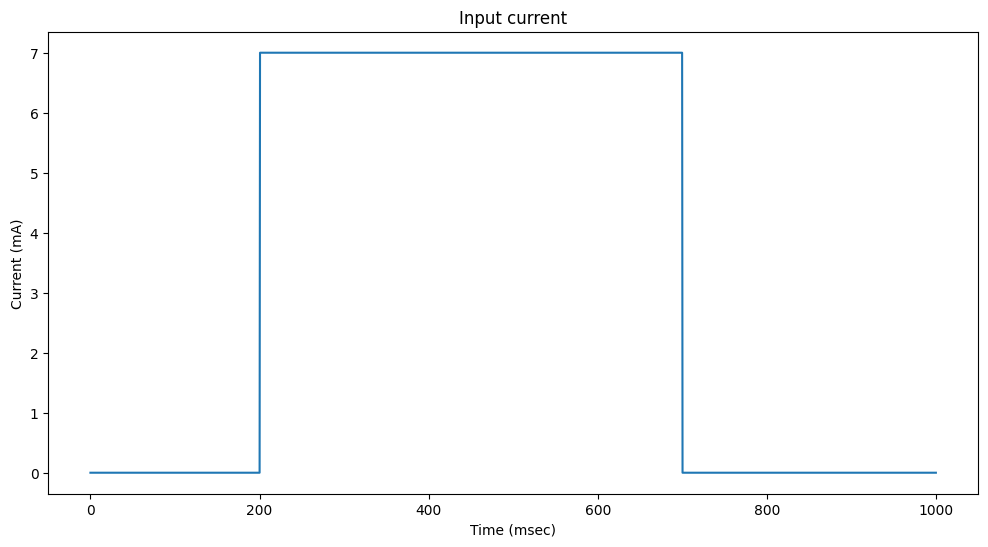

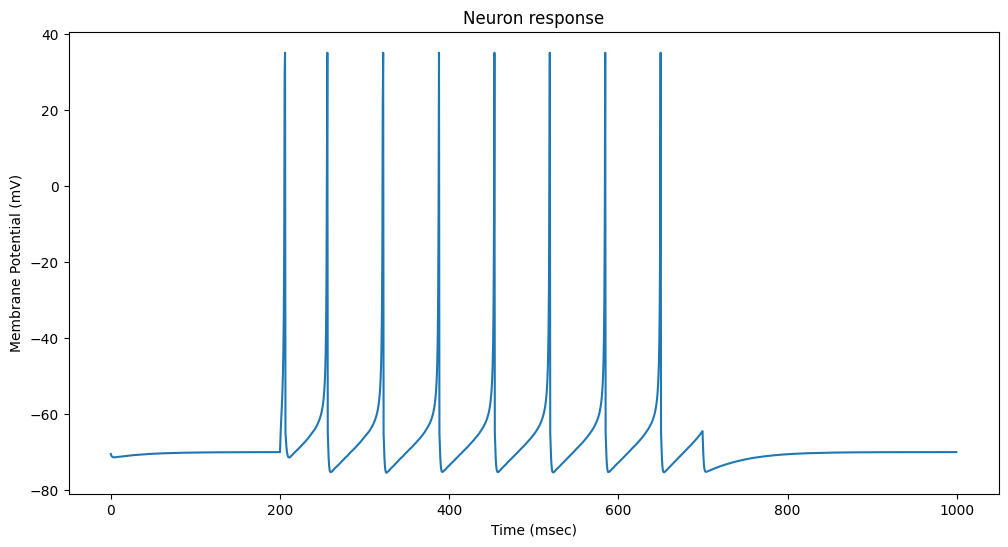

In [ ]:
plt.rcParams["figure.figsize"] =(12,6)
# Draw the input current and the membrane potential
plt.figure()
plt.title('Input current')
plt.ylabel('Current (mA)')
plt.xlabel('Time (msec)')
plt.plot(*zip(*I_in))
plt.figure()
plt.title('Neuron response')
plt.ylabel('Membrane Potential (mV)')
plt.xlabel('Time (msec)')
plt.plot(*zip(*v_out))

## Single Neuron with Synaptic Current

In [ ]:
#
# A class representing a population of simple neurons with synaptic inputs
#
class SimpleSynapticNeurons(SimpleNeurons):

    def __init__(self, n=1, m=100, A=None, B=None, C=None, D=None, W_in=None):

        # Additional model parameters
        self.m = m
        self.tau = 10.0
        if W_in is None:
            self.W_in = np.full((n,m), 0.07, dtype=np.float32)
        else:
            self.W_in = W_in
        # The reason this one is different is to allow broadcasting when subtracting v
        self.E_in = np.zeros((m), dtype=np.float32)

        # Call the parent contructor
        # This will call the methods we have overidden when building the graph
        super(SimpleSynapticNeurons, self).__init__(n, A, B, C, D)

    ########################################################
    # Override the parent graph Variables and placeholders #
    ########################################################
    def get_vars_and_ph(self):

        # Get parent grah variables and placeholders
        super(SimpleSynapticNeurons, self).get_vars_and_ph()

        # Input synapse conductance dynamics (increases on each synapse spike)
        self.g_in = tf.Variable(tf.zeros(dtype=tf.float32, shape=[self.m]),
                                    dtype=tf.float32,
                                    name='g_in')

        # We need a new placeholder to pass the input synapses behaviour at each timestep
        self.syn_has_spiked = tf.placeholder(tf.bool, shape=[self.m])


    #######################################################
    # Modify i_op in the graph of operations:             #
    #     syn_has_spiked -> g_in_op -> i_op               #
    #######################################################
    def get_input_ops(self, has_fired_op, v_op):

        # First, update synaptic conductance dynamics:
        # - increment by one the current factor of synapses that fired
        # - decrease by tau the conductance dynamics in any case
        g_in_update_op = tf.where(self.syn_has_spiked,
                                  tf.add(self.g_in, tf.ones(shape=self.g_in.shape)),
                                  tf.subtract(self.g_in, tf.multiply(self.dt,tf.divide(self.g_in, self.tau))))

        # Update the g_in variable
        g_in_op = tf.assign(self.g_in, g_in_update_op)

        # We can now evaluate the synaptic input currents
        # Isyn = Σ w_in(j)g_in(j)E_in(j) - (Σ w_in(j)g_in(j)).v(t)
        i_op = tf.subtract(tf.einsum('nm,m->n', tf.constant(self.W_in), tf.multiply(g_in_op, tf.constant(self.E_in))),
                           tf.multiply(tf.einsum('nm,m->n', tf.constant(self.W_in), g_in_op), v_op))

        # Store a reference to this operation for easier retrieval
        self.input = i_op

        return i_op

In [ ]:
##############
# Simulation #
##############

# Array of input current values
I_in = []
# Array of evaluated membrane potential values
v_out = []
# Duration of the simulation in ms
T = 1000
# Duration of each time step in ms
dt = 0.5
# Number of iterations = T/dt
steps = range(int(T / dt))
# Number of neurons
n = 1
# Number of synapses
m = 100
# Synapses firing rate
frate = 0.002

# Instantiate the population of synaptic neurons
neurons = SimpleSynapticNeurons(n, m)

with tf.Session(graph=neurons.graph) as sess:

    # Initialize v and u to their default values
    sess.run(tf.global_variables_initializer())

    # Run the simulation at each time step
    for step in steps:

        t = step * dt
        # We generate random spikes on the input synapses between 200 and 700 ms
        if t > 200 and t < 700:
            # Generate a random matrix
            r = np.random.uniform(0,1,(m))
            # A synapse has spiked when r is lower than the spiking rate
            p_syn_spike = r < frate * dt
        else:
            # No synapse activity during that period
            p_syn_spike = np.zeros((m), dtype=bool)

        feed = {neurons.syn_has_spiked: p_syn_spike, neurons.dt: [dt]}

        # Run the graph corresponding to our update ops, with our parameters
        i, v, u = sess.run([neurons.input, neurons.potential, neurons.recovery], feed_dict=feed)

        # Store values
        I_in.append((t,i))
        v_out.append((t,v))

<ipython-input-11-426a7aed5915>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _, i_mean = np.mean(np.array(I_in)[int(200/dt):int(700/dt),:], axis=0)


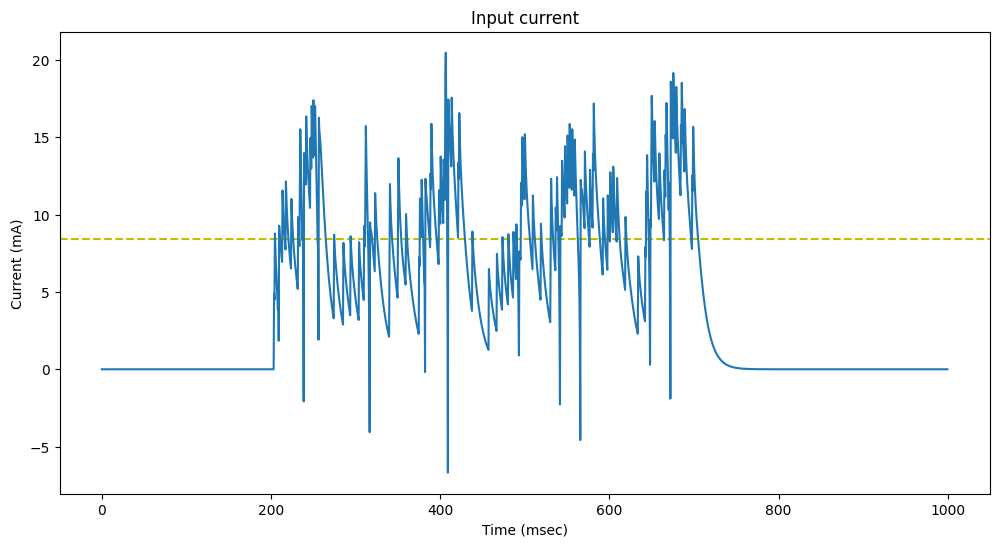

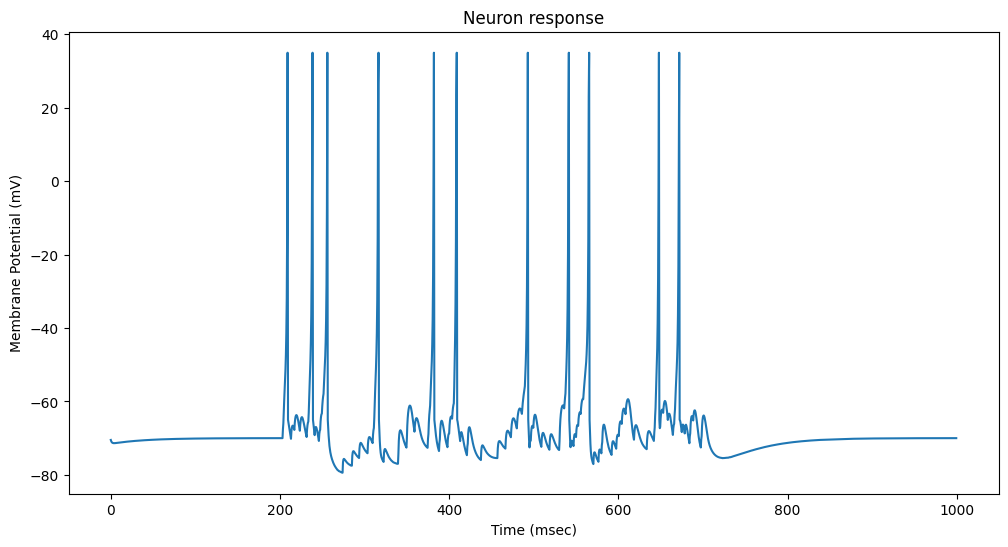

In [ ]:
plt.rcParams["figure.figsize"] =(12,6)
# Draw the input current and the membrane potential
plt.figure()
plt.title('Input current')
plt.ylabel('Current (mA)')
plt.xlabel('Time (msec)')
_, i_mean = np.mean(np.array(I_in)[int(200/dt):int(700/dt),:], axis=0)
plt.axhline(y=i_mean, color='y', linestyle='--')
plt.plot(*zip(*I_in))
plt.figure()
plt.title('Neuron response')
plt.ylabel('Membrane Potential (mV)')
plt.xlabel('Time (msec)')
plt.plot(*zip(*v_out))

## 1000 Neurons with Synaptic Input

In [ ]:
##############
# Simulation #
##############

# Duration of the simulation in ms
T = 1000
# Duration of each time step in ms
dt = 0.5
# Number of iterations = T/dt
steps = int(T / dt)
# Number of neurons
n = 1000
# Number of synapses
m = 100
# Synapses firing rate
frate = 0.002

# Array of input current values
I_in = []
# Array of evaluated membrane potential values
v_out = np.zeros((steps,n))

# Generate a random distribution for our neurons
p_neurons = np.random.uniform(0,1,(n))

# Assign neuron parameters based on the probability
a = np.full((n), 0.02, dtype=np.float32)
a[p_neurons < 0.2] = 0.1
d = np.full((n), 8.0, dtype=np.float32)
d[p_neurons < 0.2] = 2.0

# Randomly connect 10% of the neurons to the input synapses
p_syn = np.random.uniform(0,1,(n,m))
w_in = np.zeros((n,m), dtype=np.float32)
w_in[ p_syn < 0.1 ] = 0.07

# Instantiate the population of synaptic neurons
neurons = SimpleSynapticNeurons(n, m, A=a, D=d, W_in=w_in)

with tf.Session(graph=neurons.graph) as sess:

    # Initialize global variables to their default values
    sess.run(tf.global_variables_initializer())

    # Run the simulation at each time step
    for t in range(steps):

        # We generate random spikes on the input synapses between 200 and 700 ms
        if t * dt > 200 and t * dt < 700:
            # Generate a random matrix
            r = np.random.uniform(0,1,(m))
            # A synapse has spiked when r is lower than the spiking rate
            p_syn_spike = r < frate * dt
        else:
            # No synapse activity during that period
            p_syn_spike = np.zeros((m), dtype=bool)

        feed = {neurons.syn_has_spiked: p_syn_spike, neurons.dt: [dt]}

        # Run the graph corresponding to our update ops, with our parameters
        i, v, u = sess.run([neurons.input, neurons.potential, neurons.recovery], feed_dict=feed)

        # Store values
        v_out[t, :] = v

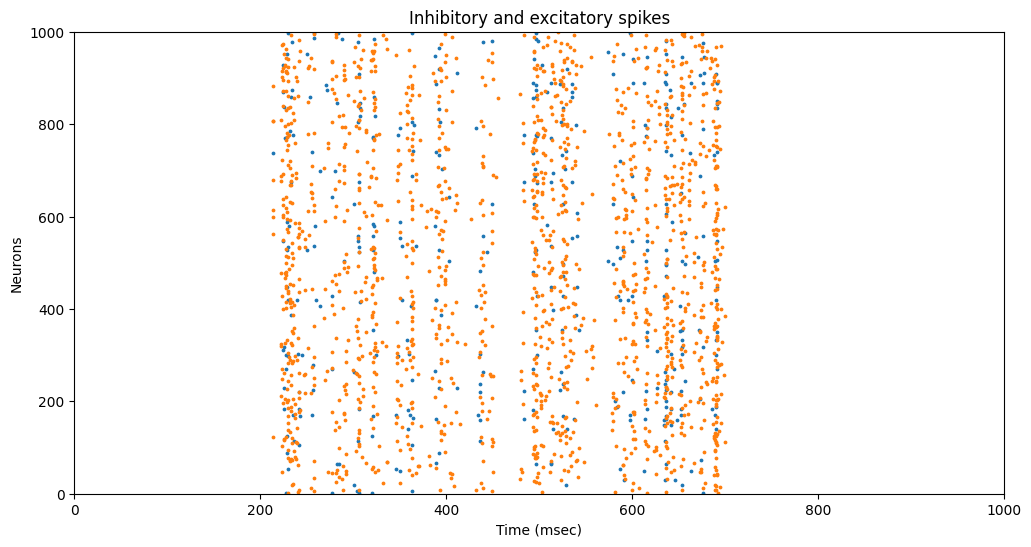

In [ ]:
plt.rcParams["figure.figsize"] =(12,6)
# Split between inhibitory and excitatory
inh_v_out = np.where(p_neurons < 0.2, v_out, 0)
exc_v_out = np.where(p_neurons >= 0.2, v_out, 0)
# Identify spikes
inh_spikes = np.argwhere(inh_v_out == 35.0)
exc_spikes = np.argwhere(exc_v_out == 35.0)
# Display spikes over time
plt.axis([0, T, 0, n])
plt.title('Inhibitory and excitatory spikes')
plt.ylabel('Neurons')
plt.xlabel('Time (msec)')
# Plot inhibitory spikes
steps, neurons = inh_spikes.T
plt.scatter(steps*dt, neurons, s=3)
# Plot excitatory spikes
steps, neurons = exc_spikes.T
plt.scatter(steps*dt, neurons, s=3)

## 1000 Neurons with Recurrent Connections

In [ ]:
#
# A class representing a population of simple neurons with synaptic inputs
#
class SimpleSynapticRecurrentNeurons(SimpleSynapticNeurons):

    def __init__(self, n=1, m=100, A=None, B=None, C=None, D=None, W_in=None, W=None, E=None):

        # Additional model parameters
        self.W = W
        self.E = E

        # Call the parent contructor
        super(SimpleSynapticRecurrentNeurons, self).__init__(n, m, A, B, C, D, W_in)

    ########################################################
    # Override the parent graph Variables and placeholders #
    ########################################################
    def get_vars_and_ph(self):

        # Get parent grah variables and placeholders
        super(SimpleSynapticRecurrentNeurons, self).get_vars_and_ph()

        # Recurrent synapse conductance dynamics (increases on each synapse spike)
        self.g = tf.Variable(tf.zeros(dtype=tf.float32, shape=[self.n]),
                             dtype=tf.float32,
                             name='g')

    #######################################################
    # Modify i_op in the graph of operations:             #
    #     syn_has_spiked -> i_in_op,i_rec_op -> i_op      #
    #######################################################
    def get_input_ops(self, has_fired_op, v_op):

        # First, update recurrent conductance dynamics:
        # - increment by one the current factor of synapses that fired
        # - decrease by tau the conductance dynamics in any case
        g_update_op = tf.where(has_fired_op,
                               tf.add(self.g, tf.ones(shape=self.g.shape)),
                               tf.subtract(self.g, tf.multiply(self.dt, tf.divide(self.g, self.tau))))

        # Update the g variable
        g_op = tf.assign(self.g, g_update_op)

        # We can now evaluate the recurrent conductance
        # I_rec = Σ wjgj(Ej -v(t))
        i_rec_op = tf.einsum('ij,j->i', tf.constant(self.W), tf.multiply(g_op, tf.subtract(tf.constant(self.E), v_op)))

        # Get the synaptic input currents from parent
        i_in_op = super(SimpleSynapticRecurrentNeurons, self).get_input_ops(has_fired_op, v_op)

        # The actual current is the sum of both currents
        i_op = i_in_op + i_rec_op

        # Store a reference to this operation for easier retrieval
        self.input = i_op

        return i_op

In [ ]:
##############
# Simulation #
##############

# Duration of the simulation in ms
T = 1000
# Duration of each time step in ms
dt = 0.5
# Number of iterations = T/dt
steps = int(T / dt)
# Number of neurons
n = 1000
# Number of synapses
m = 100
# Synapses firing rate
frate = 0.002

# Array of input current values
I_in = []
# Array of evaluated membrane potential values
v_out = np.zeros((steps,n))

# Generate a random distribution for our neurons
p_neurons = np.random.uniform(0,1,(n))

# Assign neuron parameters based on the probability
a = np.full((n), 0.02, dtype=np.float32)
a[p_neurons < 0.2] = 0.1
d = np.full((n), 8.0, dtype=np.float32)
d[p_neurons < 0.2] = 2.0

# Randomly connect 10% of the neurons to the input synapses
p_syn = np.random.uniform(0,1,(n,m))
w_in = np.zeros((n,m), dtype=np.float32)
w_in[ p_syn < 0.1 ] = 0.07

# Randomly distribute recurrent connections
w = np.zeros((n,n),  dtype=np.float32)
p_reccur = np.random.uniform(0,1,(n,n))
w[p_reccur < 0.1] = np.random.gamma(2, 0.003, size=w[p_reccur < 0.1].shape)
# Identify inhibitory to excitatory connections (receiving end is in row)
inh_2_exc = np.ix_(p_neurons >= 0.2, p_neurons < 0.2)
# Increase the strength of these connections
w[ inh_2_exc ] = 2* w[ inh_2_exc]

# Only inhibitory neurons have E=-85 mv
e = np.zeros((n), dtype=np.float32)
e[p_neurons<0.2] = -85.0

# Instantiate the population of synaptic neurons
neurons = SimpleSynapticRecurrentNeurons(n, m, A=a, D=d, W_in=w_in, W=w, E=e)

with tf.Session(graph=neurons.graph) as sess:

    # Initialize v and u to their default values
    sess.run(tf.global_variables_initializer())

    # Run the simulation at each time step
    for t in range(steps):

        # We generate random spikes on the input synapses between 200 and 700 ms
        if t * dt > 200 and t * dt < 700:
            # Generate a random matrix
            r = np.random.uniform(0,1,(m))
            # A synapse has spiked when r is lower than the spiking rate
            p_syn_spike = r < frate * dt
        else:
            # No synapse activity during that period
            p_syn_spike = np.zeros((m), dtype=bool)

        feed = {neurons.syn_has_spiked: p_syn_spike, neurons.dt: [dt]}

        # Run the graph corresponding to our update ops, with our parameters
        i, v, u = sess.run([neurons.input, neurons.potential, neurons.recovery], feed_dict=feed)

        # Store values
        v_out[t, :] = v

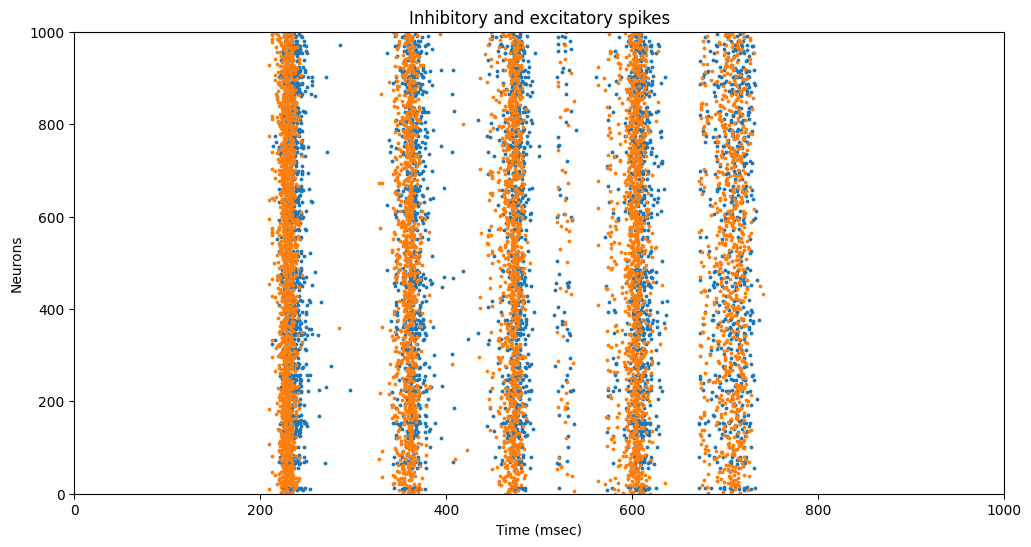

In [ ]:
plt.rcParams["figure.figsize"] =(12,6)
# Split between inhibitory and excitatory
inh_v_out = np.where(p_neurons < 0.2, v_out, 0)
exc_v_out = np.where(p_neurons >= 0.2, v_out, 0)
# Identify spikes
inh_spikes = np.argwhere(inh_v_out == 35.0)
exc_spikes = np.argwhere(exc_v_out == 35.0)
# Display spikes over time
plt.axis([0, T, 0, n])
plt.title('Inhibitory and excitatory spikes')
plt.ylabel('Neurons')
plt.xlabel('Time (msec)')
# Plot inhibitory spikes
steps, neurons = inh_spikes.T
plt.scatter(steps*dt, neurons, s=3)
# Plot excitatory spikes
steps, neurons = exc_spikes.T
plt.scatter(steps*dt, neurons, s=3)

# Leaky Integrate Fire Model

In [ ]:
# These imports will be used in the notebook
from __future__ import print_function

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# A basic LIF neuron
class LIFNeuron(object):

    def __init__(self, u_rest=0.0, u_thresh=1.0, tau_rest=4.0, r=1.0, tau=10.0):

        # Membrane resting potential in mV
        self.u_rest = u_rest
        # Membrane threshold potential in mV
        self.u_thresh = u_thresh
        # Duration of the resting period in ms
        self.tau_rest = tau_rest
        # Membrane resistance in Ohm
        self.r = r
        # Membrane time constant in ms
        self.tau = tau

        # Instantiate a graph for this neuron
        self.graph = tf.Graph()

        # Build the graph
        with self.graph.as_default():

            # Variables and placeholders
            self.get_vars_and_ph()

            # Operations
            self.input = self.get_input_op()
            self.potential = self.get_potential_op()
            # Note that input is a prerequisite of potential, so it will
            # always be evaluated when potential is

    # Variables and placeholders
    def get_vars_and_ph(self):

        # The current membrane potential
        self.u = tf.Variable(self.u_rest, dtype=tf.float32, name='u')
        # The duration left in the resting period (0 most of the time except after a neuron spike)
        self.t_rest = tf.Variable(0.0, dtype=tf.float32, name='t_rest')
        # Input current
        self.i_app = tf.placeholder(dtype=tf.float32, name='i_app')
        # The chosen time interval for the stimulation in ms
        self.dt = tf.placeholder(dtype=tf.float32, name='dt')

    # Evaluate input current
    def get_input_op(self):

        return self.i_app

    # Neuron behaviour during integration phase (below threshold)
    def get_integrating_op(self):

        # Get input current
        i_op = self.get_input_op()

        # Update membrane potential
        du_op = tf.divide(tf.subtract(tf.multiply(self.r, i_op), self.u), self.tau)
        u_op = self.u.assign_add(du_op * self.dt)
        # Refractory period is 0
        t_rest_op = self.t_rest.assign(0.0)

        return u_op, t_rest_op

        # Neuron behaviour during firing phase (above threshold)
    def get_firing_op(self):

        # Reset membrane potential
        u_op = self.u.assign(self.u_rest)
        # Refractory period starts now
        t_rest_op = self.t_rest.assign(self.tau_rest)

        return u_op, t_rest_op

    # Neuron behaviour during resting phase (t_rest > 0)
    def get_resting_op(self):

        # Membrane potential stays at u_rest
        u_op = self.u.assign(self.u_rest)
        # Refractory period is decreased by dt
        t_rest_op = self.t_rest.assign_sub(self.dt)

        return u_op, t_rest_op

    def get_potential_op(self):

        return tf.case(
            [
                (self.t_rest > 0.0, self.get_resting_op),
                (self.u > self.u_thresh, self.get_firing_op),
            ],
            default=self.get_integrating_op
        )

In [ ]:
# Simulation with square input currents

# Duration of the simulation in ms
T = 200
# Duration of each time step in ms
dt = 1
# Number of iterations = T/dt
steps = int(T / dt)
# Output variables
I = []
U = []

neuron = LIFNeuron()

with tf.Session(graph=neuron.graph) as sess:

    sess.run(tf.global_variables_initializer())

    for step in range(steps):

        t = step * dt
        # Set input current in mA
        if t > 10 and t < 30:
            i_app = 0.5
        elif t > 50 and t < 100:
            i_app = 1.2
        elif t > 120 and t < 180:
            i_app = 1.5
        else:
            i_app = 0.0

        feed = { neuron.i_app: i_app, neuron.dt: dt}

        u = sess.run(neuron.potential, feed_dict=feed)

        I.append(i_app)
        U.append(u)

Text(0.5, 0, 'Time (msec)')

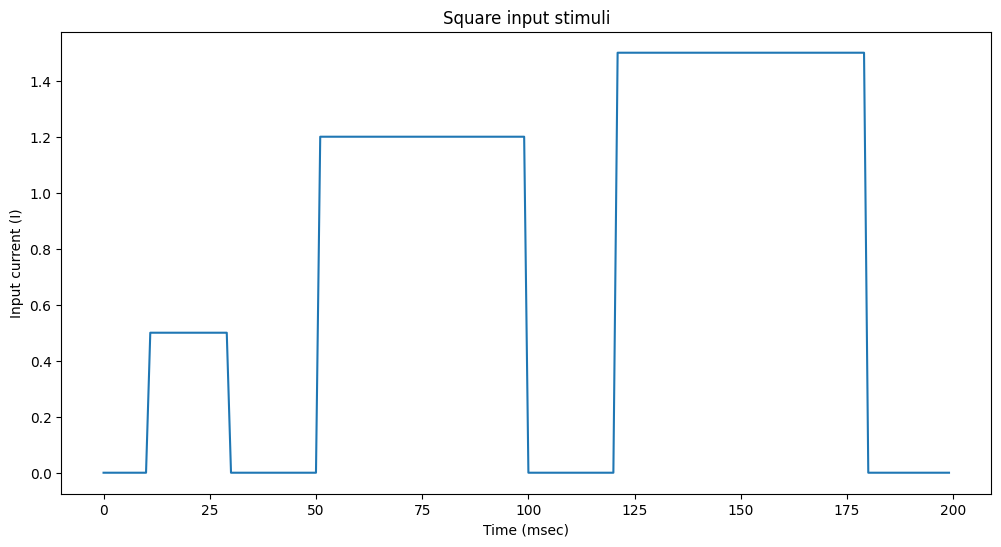

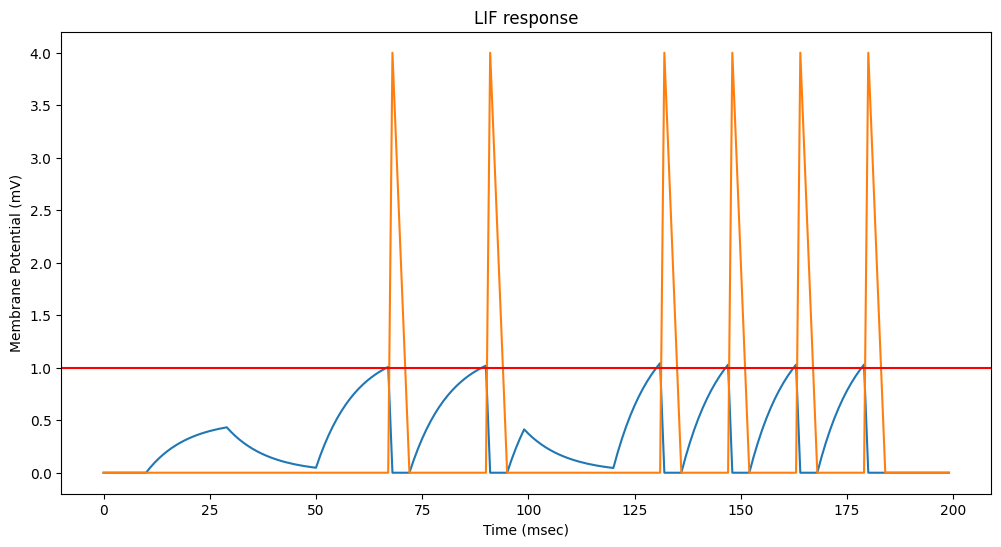

In [ ]:
plt.rcParams["figure.figsize"] =(12,6)
# Draw the input current and the membrane potential
plt.figure()
plt.plot([i for i in I])
plt.title('Square input stimuli')
plt.ylabel('Input current (I)')
plt.xlabel('Time (msec)')
plt.figure()
plt.plot([u for u in U])
plt.axhline(y=1.0, color='r', linestyle='-')
plt.title('LIF response')
plt.ylabel('Membrane Potential (mV)')
plt.xlabel('Time (msec)')

In [ ]:
# Simulation with random input currents

# Duration of the simulation in ms
T = 200
# Duration of each time step in ms
dt = 1
# Number of iterations = T/dt
steps = int(T / dt)
# Output variables
I = []
U = []

neuron = LIFNeuron()

with tf.Session(graph=neuron.graph) as sess:

    sess.run(tf.global_variables_initializer())

    for step in range(steps):

        t = step * dt
        if t > 10 and t < 180:
            i_app = np.random.normal(1.5, 1.0)
        else:
            i_app = 0.0

        feed = { neuron.i_app: i_app, neuron.dt: dt}

        u = sess.run(neuron.potential, feed_dict=feed)

        I.append(i_app)
        U.append(u)

Text(0.5, 0, 'Time (msec)')

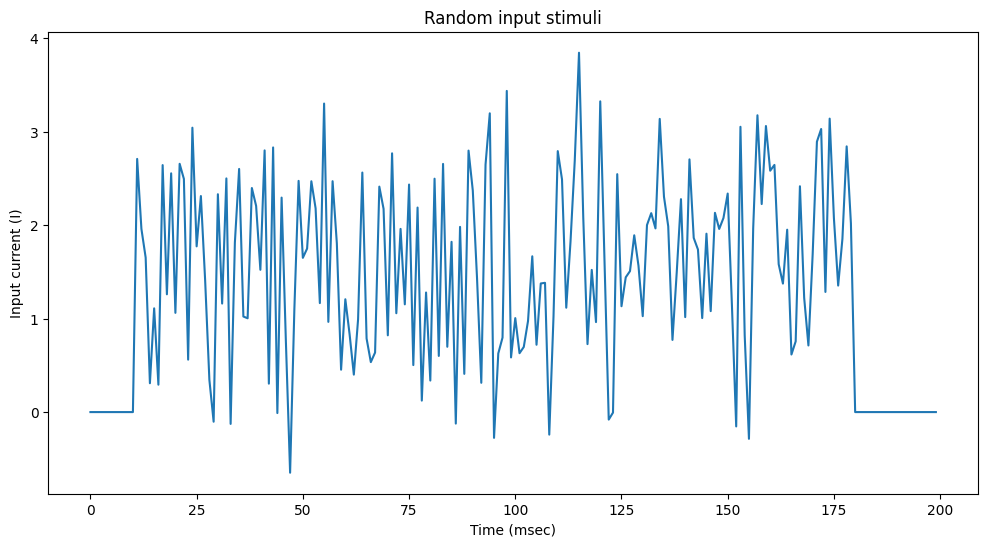

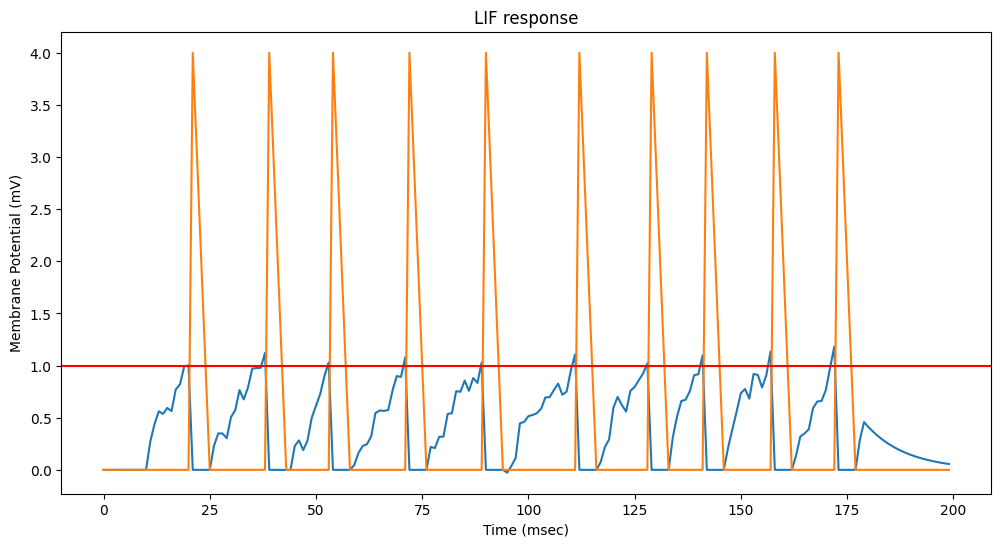

In [ ]:
plt.rcParams["figure.figsize"] =(12,6)
# Draw the input current and the membrane potential
plt.figure()
plt.plot([i for i in I])
plt.title('Random input stimuli')
plt.ylabel('Input current (I)')
plt.xlabel('Time (msec)')
plt.figure()
plt.plot([u for u in U])
plt.axhline(y=1.0, color='r', linestyle='-')
plt.title('LIF response')
plt.ylabel('Membrane Potential (mV)')
plt.xlabel('Time (msec)')

In [ ]:
# A new neuron model derived from the LIF neuron
# It takes synaptic spikes as input and remember them over a specified time period
class LIFSynapticNeuron(LIFNeuron):

    def __init__(self, n_syn, w, max_spikes=50, u_rest=0.0, u_thresh=1.0, tau_rest=4.0, r=1.0, tau=10.0, q=1.5, tau_syn=10.0):

        # Number of synapses
        self.n_syn = n_syn
        # Maximum number of spikes we remember
        self.max_spikes = max_spikes
        # The neuron synaptic 'charge'
        self.q = q
        # The synaptic time constant (ms)
        self.tau_syn = tau_syn
        # The synaptic efficacy
        self.w = w

        super(LIFSynapticNeuron, self).__init__(u_rest, u_thresh, tau_rest, r, tau)

    # Update the parent graph variables and placeholders
    def get_vars_and_ph(self):

        # Get parent grah variables and placeholders
        super(LIFSynapticNeuron, self).get_vars_and_ph()

        # Add ours

        # The history of synaptic spike times for the neuron
        self.t_spikes = tf.Variable(tf.constant(-1.0, shape=[self.max_spikes, self.n_syn], dtype=tf.float32))
        # The last index used to insert spike times
        self.t_spikes_idx = tf.Variable(self.max_spikes-1, dtype=tf.int32)
        # A placeholder indicating which synapse spiked in the last time step
        self.syn_has_spiked = tf.placeholder(shape=[self.n_syn], dtype=tf.bool)

    # Operation to update spike times
    def update_spike_times(self):

        # Increase the age of older spikes
        old_spikes_op = self.t_spikes.assign_add(tf.where(self.t_spikes >=0,
                                                          tf.constant(1.0, shape=[self.max_spikes, self.n_syn]) * self.dt,
                                                          tf.zeros([self.max_spikes, self.n_syn])))

        # Increment last spike index (modulo max_spikes)
        new_idx_op = self.t_spikes_idx.assign(tf.mod(self.t_spikes_idx + 1, self.max_spikes))

        # Create a list of coordinates to insert the new spikes
        idx_op = tf.constant(1, shape=[self.n_syn], dtype=tf.int32) * new_idx_op
        coord_op = tf.stack([idx_op, tf.range(self.n_syn)], axis=1)

        # Create a vector of new spike times (non-spikes are assigned a negative time)
        new_spikes_op = tf.where(self.syn_has_spiked,
                                 tf.constant(0.0, shape=[self.n_syn]),
                                 tf.constant(-1.0, shape=[self.n_syn]))

        # Replace older spikes by new ones
        return tf.scatter_nd_update(old_spikes_op, coord_op, new_spikes_op)

    # Override parent get_input_op method
    def get_input_op(self):

        # Update our memory of spike times with the new spikes
        t_spikes_op = self.update_spike_times()

                # Evaluate synaptic input current for each spike on each synapse
        i_syn_op = tf.where(t_spikes_op >=0,
                            self.q/self.tau_syn * tf.exp(tf.negative(t_spikes_op/self.tau_syn)),
                            t_spikes_op*0.0)

        # Add each synaptic current to the input current
        i_op =  tf.reduce_sum(self.w * i_syn_op)

        return tf.add(self.i_app, i_op)

In [ ]:
# Simulation with synaptic input currents

# Duration of the simulation in ms
T = 200
# Duration of each time step in ms
dt = 1
# Number of iterations = T/dt
steps = int(T / dt)
# Number of synapses
n_syn = 25
# Spiking frequency in Hz
f = 20
# We need to keep track of input spikes over time
syn_has_spiked = np.full((steps,n_syn), False)
# We define the synaptic efficacy as a random vector
W = np.random.normal(1.0, 0.5, size=n_syn)
# Output variables
I = []
U = []

# Instantiate our synaptic LIF neuron, with a memory of 200 events
# Note that in practice, a much shorter period is required as the
# contribution of each synapse decreases very rapidly
neuron = LIFSynapticNeuron(n_syn=n_syn, w=W, max_spikes=200)

with tf.Session(graph=neuron.graph) as sess:

    sess.run(tf.global_variables_initializer())

    for step in range(steps):

        t = step * dt

        if t > 10 and t < 180:
            r = np.random.uniform(0,1, size=(n_syn))
            syn_has_spiked[step,:] = r < f * dt * 1e-3

        feed = { neuron.i_app: 0.0, neuron.syn_has_spiked: syn_has_spiked[step], neuron.dt: dt}
        i, u = sess.run([neuron.input, neuron.potential], feed_dict=feed)

        I.append(i)
        U.append(u)

Text(0.5, 0, 'Time (msec)')

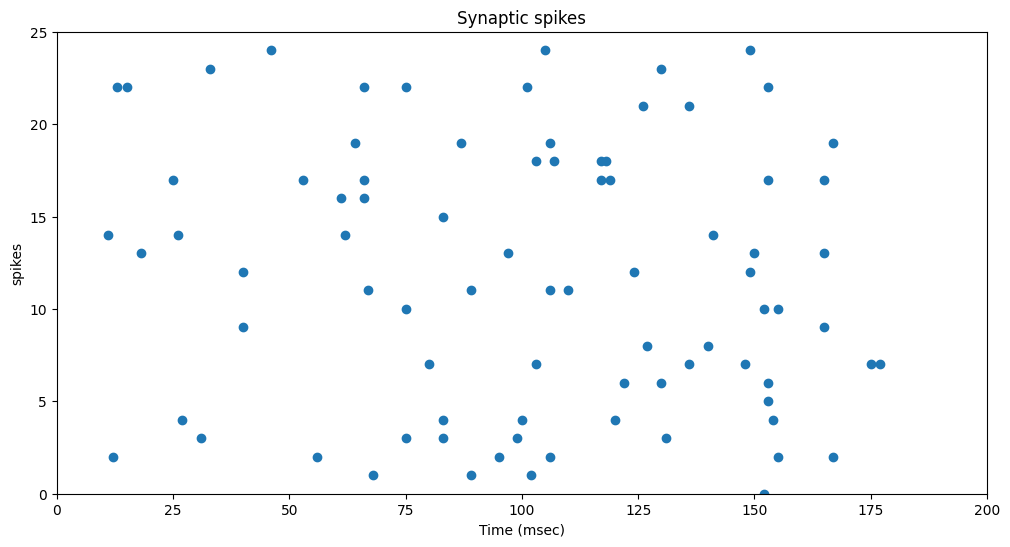

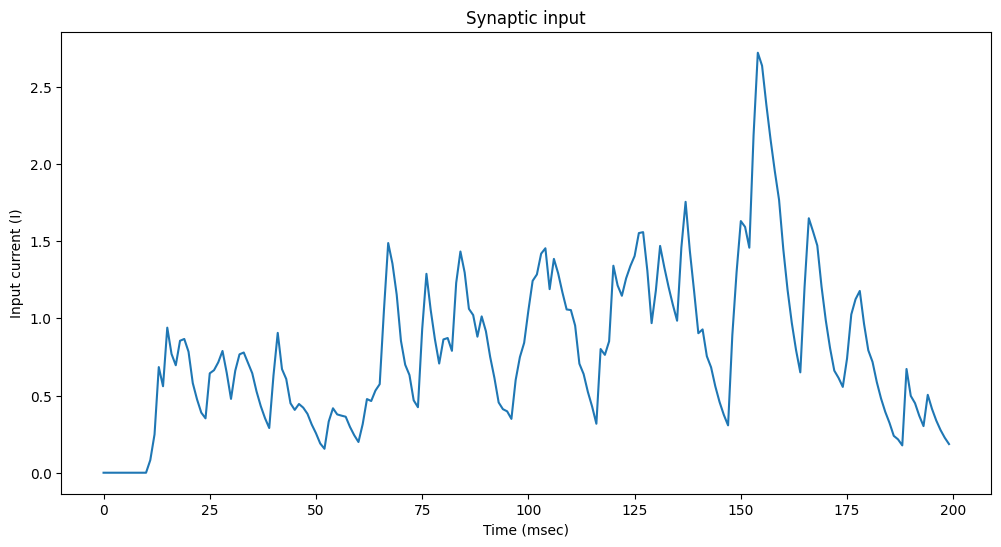

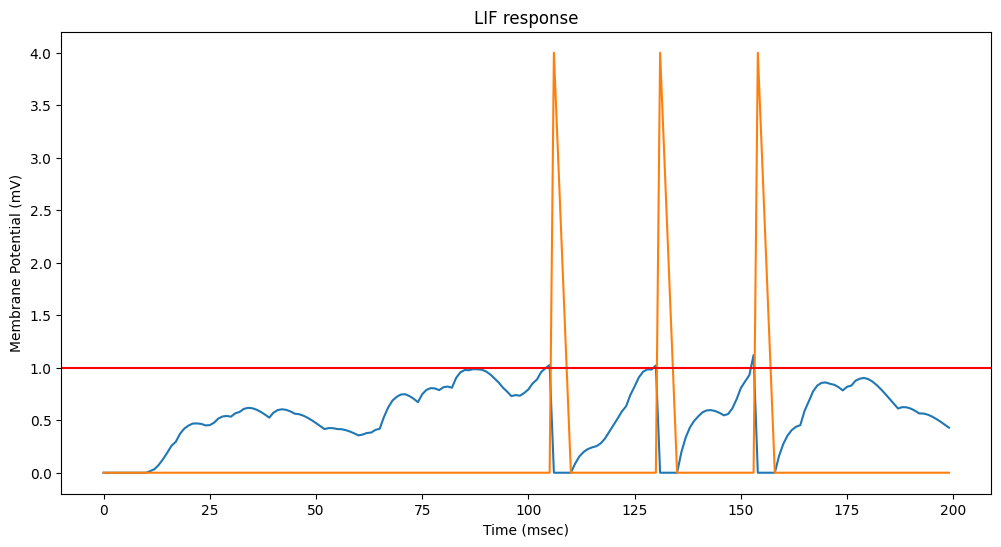

In [ ]:
plt.rcParams["figure.figsize"] =(12,6)
# Draw spikes
spikes = np.argwhere(syn_has_spiked)
t, s = spikes.T
plt.figure()
plt.axis([0, T, 0, n_syn])
plt.title('Synaptic spikes')
plt.ylabel('spikes')
plt.xlabel('Time (msec)')
plt.scatter(t, s)
# Draw the input current and the membrane potential
plt.figure()
plt.plot([i for i in I])
plt.title('Synaptic input')
plt.ylabel('Input current (I)')
plt.xlabel('Time (msec)')
plt.figure()
plt.plot([u for u in U])
plt.axhline(y=1.0, color='r', linestyle='-')
plt.title('LIF response')
plt.ylabel('Membrane Potential (mV)')
plt.xlabel('Time (msec)')